# Import libraries

In [1]:
#required libraries

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch
warnings.filterwarnings('ignore')

In [2]:
#setting the manual seed

torch.manual_seed(0)

In [3]:
#generate custom color map

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# Generate Dataset

In [4]:
#generate data using make_blobs function from sklearn.
#centers = 4 indicates different types of classes

data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


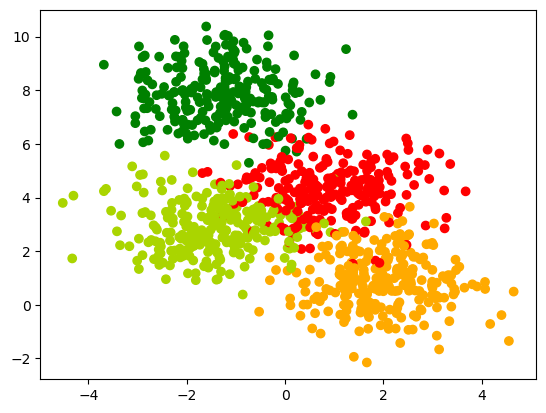

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
#splitting the data into train and test

X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


# Using torch tensors and autograd

In [7]:
#converting the numpy array to torch tensors
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [8]:
#function for computing forward pass in the network
def model(x):
    a1 = torch.matmul(x, weights1) + bias1 # (N, 2) x (2, 2) -> (N, 2)
    h1 = a1.sigmoid() # (N, 2)
    a2 = torch.matmul(h1, weights2) + bias2 # (N, 2) x (2, 4) -> (N, 4)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # (N, 4)
    return h2

In [9]:
#demo of how we calculate the cross entropy loss

y_hat = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.8, 0.1, 0.05, 0.05]])
y = torch.tensor([2, 0])
(-y_hat[range(y_hat.shape[0]), y].log()).mean().item()
(torch.argmax(y_hat, dim=1) == y).float().mean().item()

0.5

In [8]:
#function to calculate loss of a function.
#y_hat -> predicted & y -> actual

def loss_fn(y_hat, y):
    return -(y_hat[range(y.shape[0]), y].log()).mean()

In [14]:
#function to calculate accuracy of model
def accuracy(y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().mean()

In [12]:
plt.style.use("seaborn")

# Training Model

In [13]:
#set the seed
torch.manual_seed(0)

#initialize the weights and biases using He Initialization
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

#set the parameters for training the model
learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()
X_val = X_val.float()
Y_val = Y_val.long()

loss_arr = []
acc_arr = []
val_acc_arr = []

#training the network
for epoch in range(epochs):
    y_hat = model(X_train)  #compute the predicted distribution
    loss = loss_fn(y_hat, Y_train) #compute the loss of the network
    loss.backward() #backpropagate the gradients
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    with torch.no_grad(): #update the weights and biases
        val_acc_arr.append(accuracy(model(X_val),Y_val))
        
        weights1 -= weights1.grad * learning_rate
        bias1 -= bias1.grad * learning_rate
        weights2 -= weights2.grad * learning_rate
        bias2 -= bias2.grad * learning_rate
        weights1.grad.zero_()
        bias1.grad.zero_()
        weights2.grad.zero_()
        bias2.grad.zero_()

plt.plot(loss_arr, 'r-', label='loss')
plt.plot(acc_arr, 'b-', label='train accuracy')
plt.plot(val_acc_arr, 'g-', label='val accuracy')
plt.title("Loss plot - Using tensors and autograd")
plt.xlabel("Epoch")
plt.legend(loc='best')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

NameError: name 'accuracy' is not defined

## Using NN.Functional

In [14]:
import torch.nn.functional as F

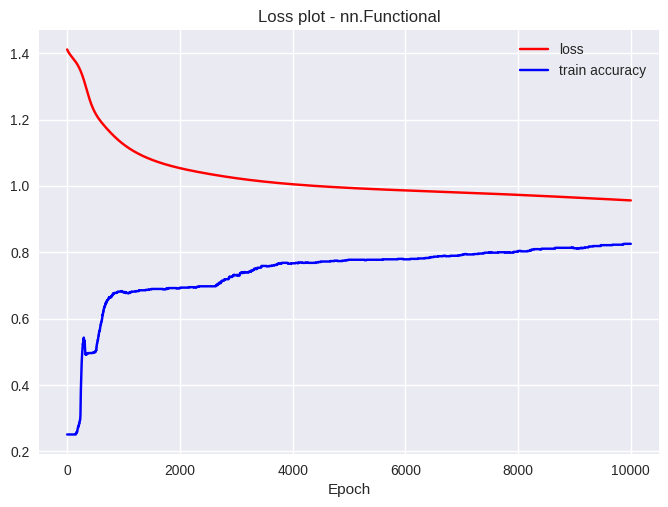

Loss before training 1.4111982583999634
Loss after training 0.9561847448348999


In [15]:
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

loss_arr = []
acc_arr = []

for epoch in range(epochs):
    y_hat = model(X_train) #compute the predicted distribution
    loss = F.cross_entropy(y_hat, Y_train) #just replace the loss function with built in function
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    with torch.no_grad():
        weights1 -= weights1.grad * learning_rate
        bias1 -= bias1.grad * learning_rate
        weights2 -= weights2.grad * learning_rate
        bias2 -= bias2.grad * learning_rate
        weights1.grad.zero_()
        bias1.grad.zero_()
        weights2.grad.zero_()
        bias2.grad.zero_()

plt.plot(loss_arr, 'r-', label='loss')
plt.plot(acc_arr, 'b-', label='train accuracy')
plt.legend(loc='best')
plt.title("Loss plot - nn.Functional")
plt.xlabel("Epoch")
plt.show()   
    
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

## Using NN.Parameter

In [16]:
import torch.nn as nn

In [17]:
class FirstNetwork(nn.Module):
  
    def __init__(self):    
        super().__init__()
        torch.manual_seed(0)
        #wrap all the weights and biases inside nn.parameter()
        self.weights1 = nn.Parameter(torch.randn(2, 2) / math.sqrt(2))
        self.bias1 = nn.Parameter(torch.zeros(2))
        self.weights2 = nn.Parameter(torch.randn(2, 4) / math.sqrt(2))
        self.bias2 = nn.Parameter(torch.zeros(4))
    
    def forward(self, X):
        a1 = torch.matmul(X, self.weights1) + self.bias1
        h1 = a1.sigmoid()
        a2 = torch.matmul(h1, self.weights2) + self.bias2
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [18]:
def fit(epochs = 10000, learning_rate = 0.2, title = ""):
    loss_arr = []
    acc_arr = []
    for epoch in range(epochs):
        y_hat = model(X_train) #forward pass
        loss = F.cross_entropy(y_hat, Y_train) #loss calculation
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train))
        loss.backward() #backpropagation
        with torch.no_grad():
            #updating the parameters
            for param in model.parameters():
                param -= learning_rate * param.grad
            model.zero_grad() #setting the gradients to zero
        
    plt.plot(loss_arr, 'r-', label='loss')
    plt.plot(acc_arr, 'b-', label='train accuracy')
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.show()      
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

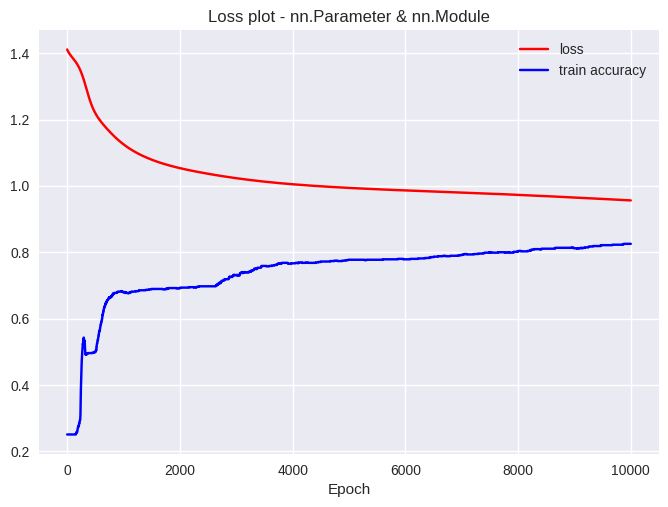

Loss before training 1.4111982583999634
Loss after training 0.9561847448348999


In [19]:
#we first have to instantiate our model
model = FirstNetwork() 

#call fit method
fit(10000,0.2,"Loss plot - nn.Parameter & nn.Module")

## Using NN.Linear and Optim

In [15]:
class FirstNetwork_v1(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(2, 2) #automatically defines weights and biases
        self.lin2 = nn.Linear(2, 4)
    
    def forward(self, X):
        a1 = self.lin1(X) #computes the dot product and adds bias
        h1 = a1.sigmoid()
        a2 = self.lin2(h1) #computes dot product and adds bias
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

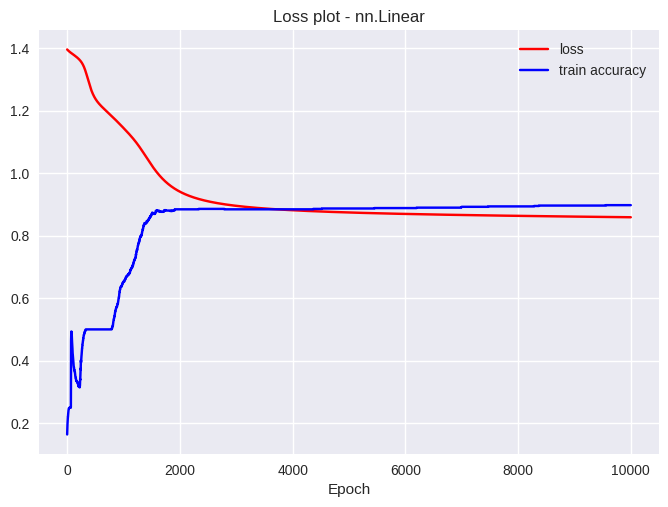

Loss before training 1.3951597213745117
Loss after training 0.8586326241493225


In [21]:
model = FirstNetwork_v1()
fit(10000,0.2,"Loss plot - nn.Linear")

In [22]:
from torch import optim

In [23]:
def fit_v1(epochs = 10000, learning_rate = 0.2, title = ""):
    loss_arr = []
    acc_arr = []
    
    opt = optim.SGD(model.parameters(), lr=learning_rate) #define optimizer
  
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = F.cross_entropy(y_hat, Y_train)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train))

        loss.backward() 
        opt.step() #updating each parameter.
        opt.zero_grad()  #resets the gradient to 0
        
    plt.plot(loss_arr, 'r-', label='loss')
    plt.plot(acc_arr, 'b-', label='train accuracy')
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.show()      
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

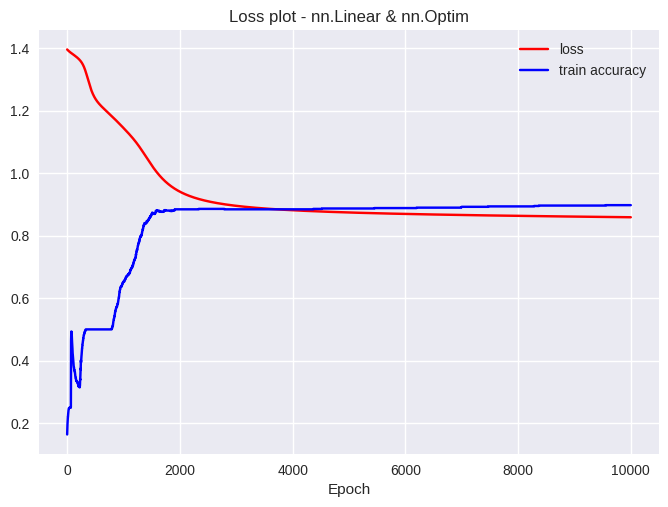

Loss before training 1.3951597213745117
Loss after training 0.8586326241493225


In [24]:
model = FirstNetwork_v1()
fit_v1(10000, 0.2, "Loss plot - nn.Linear & nn.Optim")

## Using NN.Sequential

In [15]:
import torch.nn as nn
class FirstNetwork_v2(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.network = nn.Sequential( #sequential operation
            nn.Linear(2, 2), 
            nn.Sigmoid(), 
            nn.Linear(2, 4), 
            nn.Softmax())

    def forward(self, X):
        return self.network(X)

In [16]:
model = FirstNetwork_v2() #object

def fit_v2(x, y, model, opt, loss_fn, epochs = 10000):
    """Generic function for training a model """
    for epoch in range(epochs):
        loss = loss_fn(model(x), y) 

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item()

In [17]:
#define loss 
loss_fn = F.cross_entropy
#define optimizer 
opt = optim.SGD(model.parameters(), lr=0.2)

#training model 
fit_v2(X_train, Y_train, model, opt, loss_fn)

0.19217288494110107

## Running it on GPUs

In [34]:
torch.cuda.is_available()

True

In [35]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #create a device

In [36]:
device

device(type='cuda')

In [37]:
#moving inputs to GPU
X_train=X_train.to(device)
Y_train=Y_train.to(device)

model = FirstNetwork_v2()
model.to(device) #moving the network to GPU

#calculate time
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, model, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.3951594829559326
Time taken 4.284177303314209


In [38]:
class FirstNetwork_v3(nn.Module):
  
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(2, 1024*4), 
            nn.Sigmoid(), 
            nn.Linear(1024*4, 4), 
            nn.Softmax())

    def forward(self, X):
        return self.net(X)

In [39]:

X_train=X_train.to(device)
Y_train=Y_train.to(device)

#training on gpu
fn = FirstNetwork_v3()
fn.to(device)

tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.3890228271484375
Time taken 5.586082696914673


## Exercises

1. Try out a deeper neural network, eg. 2 hidden layers
2. Try out different parameters in the optimizer (eg. try momentum, nestrov) -> check `optim.SGD` docs
3. Try out other optimization methods (eg. RMSProp and Adam) which are supported in `optim`
4. Try out different initialisation methods which are supported in `nn.init` 

## Different Weight Initlialisation

In [ ]:
import torch.nn as nn
import torch

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear: 
        torch.nn.init.xavier_uniform_(m.weight)  # Fills the input Tensor with values using a uniform distribution
        #torch.nn.init.kaiming_uniform_(m.weight) #Using He Initialisation 
        m.bias.data.fill_(0.01)
        

In [ ]:
net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)

In [ ]:
#https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

# My Codes

In [9]:
import torch.nn as nn
import torch.optim as opt


In [17]:
class Mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(2,5),
            nn.ReLU(),
            nn.Linear(5,4),
            nn.Softmax()
        )
        
    def forward(self,X):
        return self.network(X)

In [18]:
X_train = X_train.float()
Y_train = Y_train.long()
X_val = X_val.float()
Y_val = Y_val.long()



In [19]:
def compute_loss(Y_hat,Y):
    sum=0
    n=Y.shape[0]
    for i in range(n):
        sum+=(Y_hat[i][Y[i]].log())
    print(sum)
    return -sum/n

In [20]:
model=Mymodel()
optimizer = opt.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_lst=[]
for i in range(5):
    y_hat=model(X_train)
    print(y_hat)
    loss=torch.nn.CrossEntropyLoss(y_hat,Y_train)
    # loss1=compute_loss(y_hat,Y_train)
    print(loss)
    # print(loss1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    

tensor([[0.3633, 0.1766, 0.2588, 0.2013],
        [0.3687, 0.1688, 0.2544, 0.2080],
        [0.3716, 0.1646, 0.2519, 0.2119],
        ...,
        [0.3542, 0.1520, 0.2676, 0.2262],
        [0.3749, 0.1598, 0.2490, 0.2162],
        [0.3658, 0.1731, 0.2568, 0.2043]], grad_fn=<SoftmaxBackward0>)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous